In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
train_data_file = '../data/exercise_files/train.h5ad'
test_data_file = '../data/exercise_files/test.h5ad'

In [3]:
adata_train = sc.read_h5ad(train_data_file)
adata_test = sc.read_h5ad(test_data_file)
adata_train.X = adata_train.X.toarray()
adata_train.layers['counts'] = adata_train.X

In [4]:
print(adata_train.shape)
print(adata_test.shape)

(7000, 27037)
(7000, 27037)


In [5]:
adata_train.obs.head()

,cell_type,original_cell_type
run_4_PC-12D.ACTTCCGTTAGTAACGGTC-0,Placodal ectoderm,Placodal area
run_21_PB-02H_S112.TGCGTAGTTCGAGCTGCCA-10,Hindgut,Midgut/Hindgut epithelial cells
run_14_PX-06G_S143.GCTTCTGGTTTCTTAATAA-2,Dorsal spinal cord progenitors,Spinal cord dorsal progenitors
run_16_PC-10C_S267.AAAGCTGATTTTACGATGAA-4,Hindgut,Gut
run_4_PE-02C.ACGCTTATATTGACGCTCCG-0,Midbrain/Hindbrain boundary,Posterior roof plate


In [6]:
adata_train.var_names

Index(['ENSMUSG00000051951', 'ENSMUSG00000089699', 'ENSMUSG00000102343',
       'ENSMUSG00000025900', 'ENSMUSG00000025902', 'ENSMUSG00000104328',
       'ENSMUSG00000033845', 'ENSMUSG00000025903', 'ENSMUSG00000104217',
       'ENSMUSG00000033813',
       ...
       'ENSMUSG00000064354', 'ENSMUSG00000064356', 'ENSMUSG00000064357',
       'ENSMUSG00000064358', 'ENSMUSG00000064360', 'ENSMUSG00000065947',
       'ENSMUSG00000064363', 'ENSMUSG00000064367', 'ENSMUSG00000064368',
       'ENSMUSG00000064370'],
      dtype='object', length=27037)

In [7]:
adata_train.layers['X_previous'].shape

(7000, 27037)

In [8]:
training_label_counts = adata_train.obs['cell_type'].value_counts()
test_label_counts = adata_test.obs['cell_type'].value_counts()
merged_label_counts = pd.merge(training_label_counts, test_label_counts, on='cell_type', suffixes=['_train', '_test'])

In [9]:
merged_label_counts.index

CategoricalIndex(['MEP', 'Venous endothelium', 'Spinal cord progenitors',
                  'Cardiomyocytes SHF 2', 'Late dorsal forebrain progenitors',
                  'Midbrain progenitors', 'Erythroid', 'Optic vesicle',
                  'Early dorsal forebrain progenitors', 'Foregut', 'Hindgut',
                  'Surface ectoderm', 'Cardiomyocytes FHF 1',
                  'Dorsal midbrain neurons', 'Blood progenitors',
                  'Endocardium', 'Otic neural progenitors',
                  'Intermediate mesoderm', 'Midbrain/Hindbrain boundary',
                  'Migratory neural crest', 'Kidney primordium', 'Notochord',
                  'Limb mesoderm', 'Otic placode', 'Amniotic ectoderm',
                  'Placodal ectoderm', 'Ventral hindbrain progenitors',
                  'Sclerotome', 'Haematoendothelial progenitors',
                  'Frontonasal mesenchyme', 'Dorsal spinal cord progenitors',
                  'EMP', 'NMPs/Mesoderm-biased', 'Hindbrain floor pla

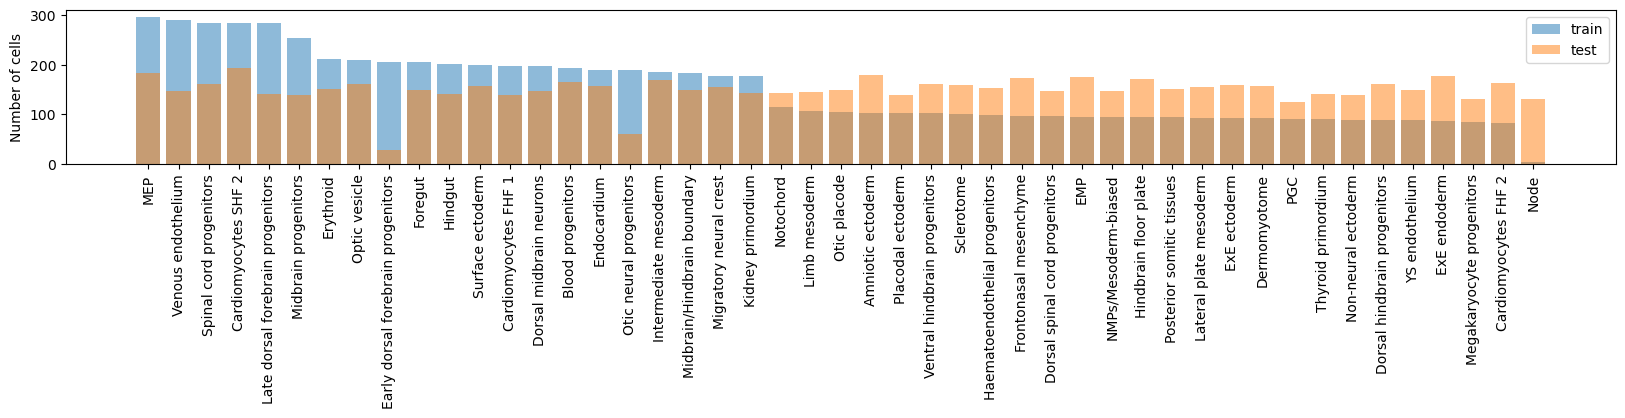

In [10]:
plt.figure(figsize=(20,2))
plt.bar(merged_label_counts.index, merged_label_counts['count_train'],alpha=0.5, label='train')
plt.bar(merged_label_counts.index, merged_label_counts['count_test'], alpha=0.5, label='test')
plt.ylabel("Number of cells")
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [11]:
annot = sc.queries.biomart_annotations('mmusculus', ['ensembl_gene_id', 'external_gene_name']).set_index('ensembl_gene_id')

In [12]:
adata_train.var[annot.columns] = annot
adata_train.var['external_gene_name'] = adata_train.var['external_gene_name'].astype(str)
adata_train.var['mt'] = adata_train.var['external_gene_name'].str.startswith("mt-").astype(bool)
adata_train = adata_train[:, ~adata_train.var['mt'].isnull()]

In [13]:
train_expressions = adata_train.X
print(np.sum(train_expressions==0))
print(train_expressions.size)

176535375
189259000


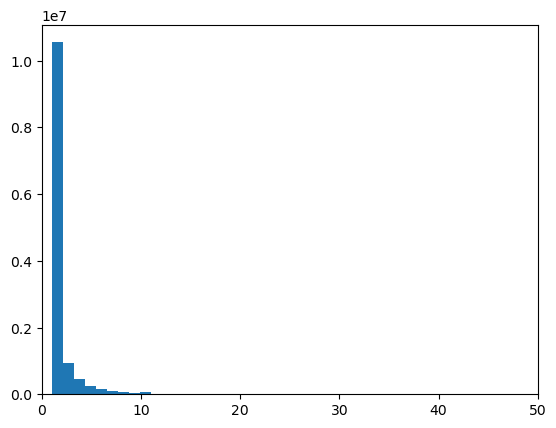

In [14]:
plt.hist(train_expressions[train_expressions!=0].flatten(), bins=1024)
plt.xlim(0,50)
plt.show()

In [15]:
adata_train.layers["counts"] = adata_train.X.copy()
adata_train.var_names = adata_train.var['external_gene_name']
adata_train.var_names_make_unique()
sc.pp.calculate_qc_metrics(adata_train, qc_vars='mt', inplace=True, log1p=False)

/var/folders/yw/486n_std62vfzrxvh1t8_94m0000gn/T/ipykernel_2019/3642575388.py:1: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata_train.layers["counts"] = adata_train.X.copy()


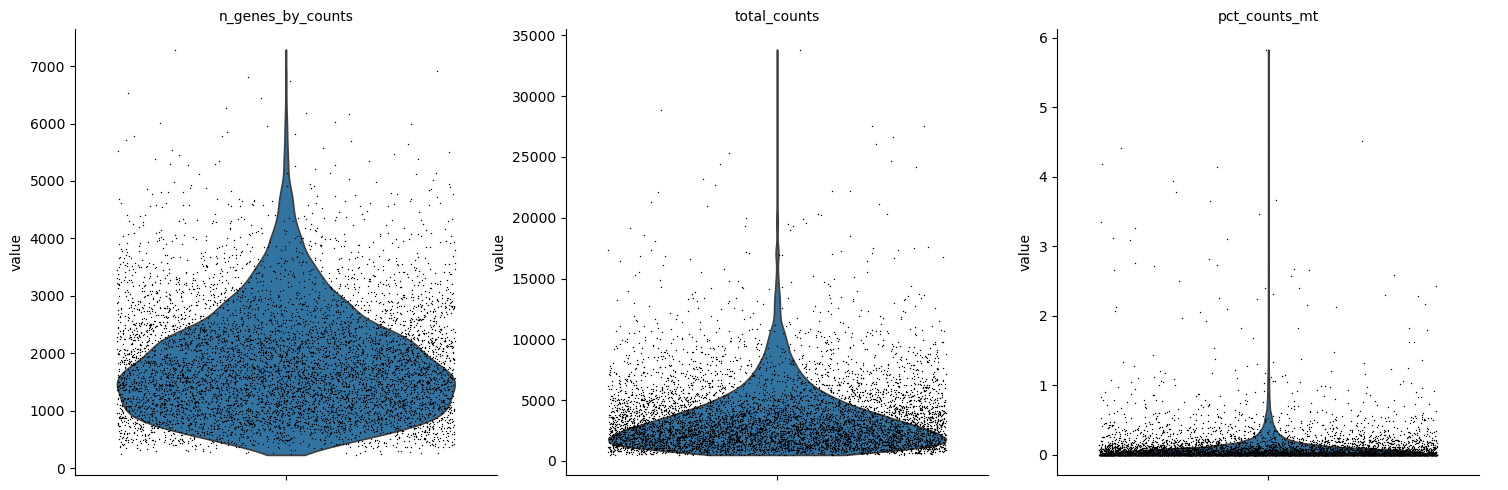

In [18]:
sc.pl.violin(
    adata_train,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

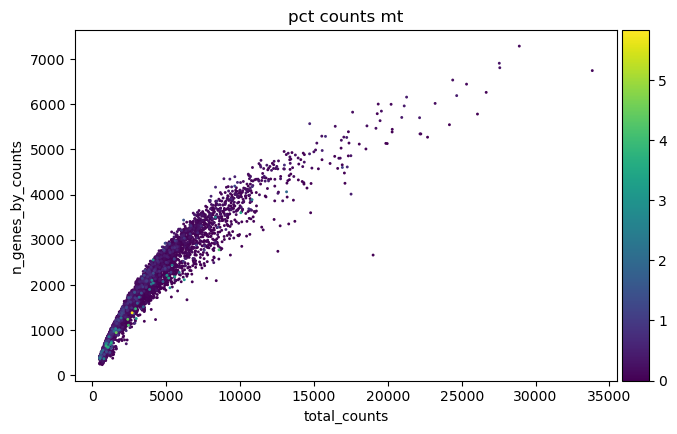

In [20]:
sc.pl.scatter(adata_train, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [21]:
sc.pp.scrublet(adata_train)
sc.pp.normalize_total(adata_train)
sc.pp.log1p(adata_train)

In [22]:
normalized_train_expressions = adata_train.X
print(normalized_train_expressions[normalized_train_expressions==0].size)
print(normalized_train_expressions.size)

176535375
189259000


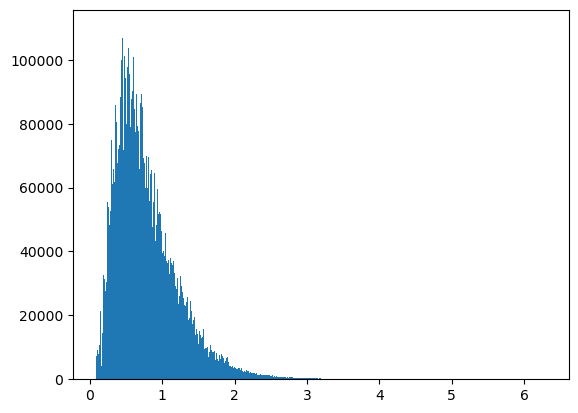

In [23]:
plt.hist(normalized_train_expressions[normalized_train_expressions!=0].flatten(), bins=1024)
plt.show()

/var/folders/yw/486n_std62vfzrxvh1t8_94m0000gn/T/ipykernel_2019/1196727119.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


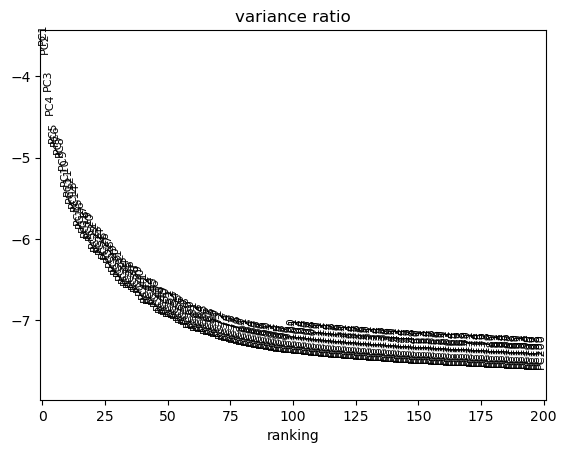

In [24]:
n_comps = 200
sc.tl.pca(adata_train, n_comps=n_comps)
fig = sc.pl.pca_variance_ratio(adata_train, n_pcs=n_comps, log=True, show=False)
fig = plt.gcf()
plt.tight_layout()

In [ ]:
sc.pp.neighbors(adata_train)
sc.tl.umap(adata_train)

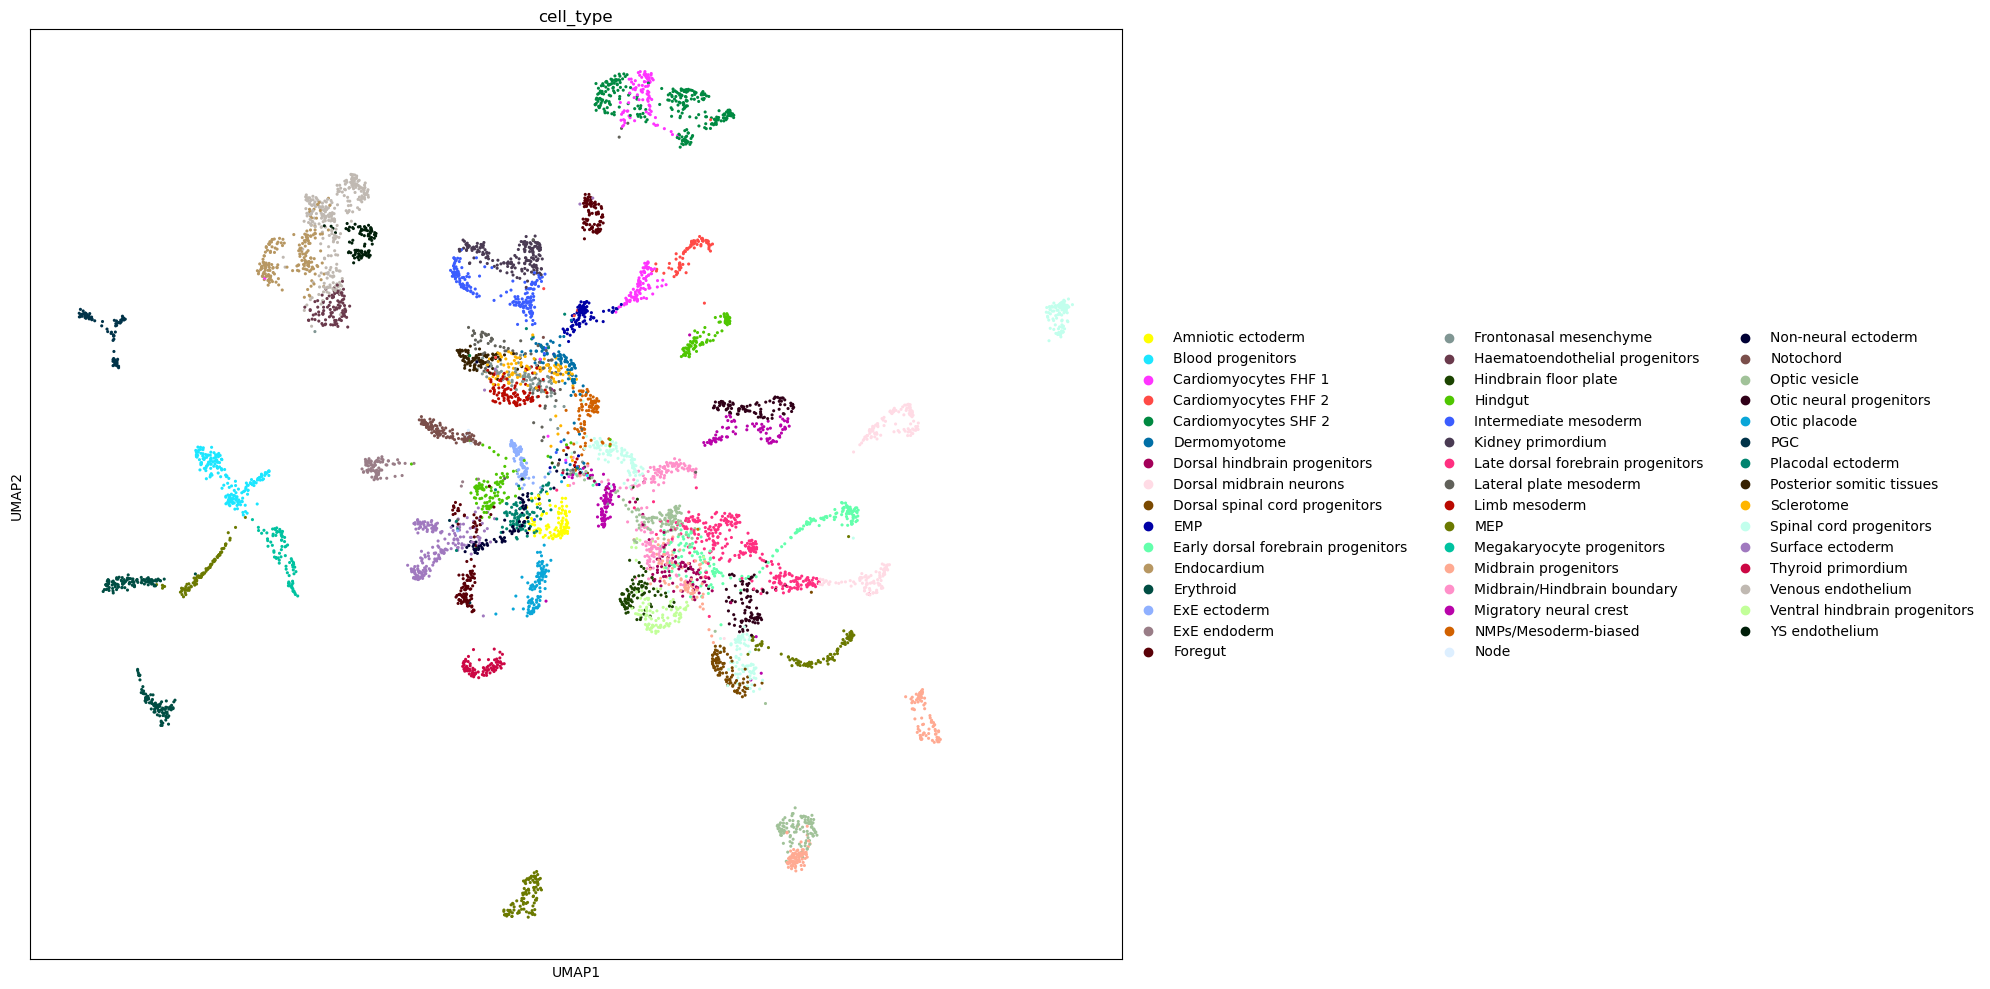

In [26]:
fig = sc.pl.umap(
    adata_train,
    color="cell_type",
    size=20,
    show=False
)
fig = plt.gcf()
fig.set_figheight(10)
fig.set_figwidth(20)

plt.tight_layout()

/var/folders/yw/486n_std62vfzrxvh1t8_94m0000gn/T/ipykernel_2019/3420815362.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


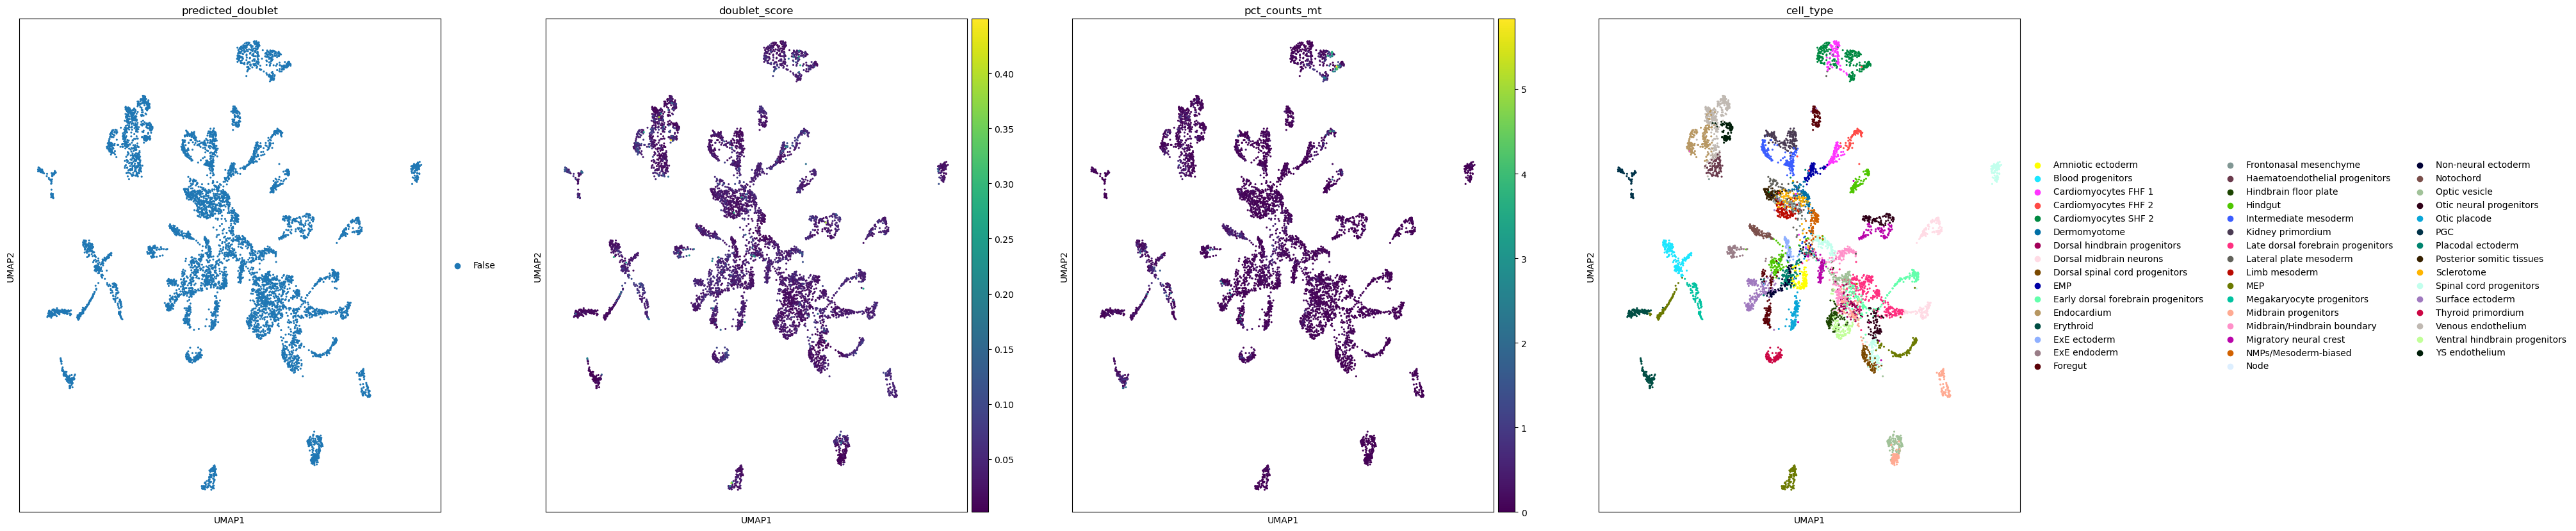

In [27]:
fig = sc.pl.umap(
    adata_train,
    color=['predicted_doublet',
           'doublet_score',
           'pct_counts_mt',
           'cell_type'
           ],
    size=20,
    show=False
)
fig = plt.gcf()
fig.set_figheight(10)
fig.set_figwidth(40)

plt.tight_layout()

In [28]:
adata_train.obs['predicted_doublet'].sum()

np.int64(0)

In [45]:
adata_train.var_names

Index(['Xkr4', 'Gm1992', 'Gm37381', 'Rp1', 'Sox17', 'Gm37323', 'Mrpl15',
       'Lypla1', 'Gm37988', 'Tcea1',
       ...
       'mt-Co2', 'mt-Atp8', 'mt-Atp6', 'mt-Co3', 'mt-Nd3', 'mt-Nd4l', 'mt-Nd4',
       'mt-Nd5', 'mt-Nd6', 'mt-Cytb'],
      dtype='object', name='external_gene_name', length=27037)

In [42]:
adata_train.X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(7000, 27037), dtype=float32)

In [62]:
context_length = 2048

In [74]:
top_indexes_each_row = np.flip(np.argsort(adata_train.X, axis=1), axis=1)
top_context_len_one_based_indexes_each_row = top_indexes_each_row[:,0:context_length]+1
cls_array = np.zeros((top_context_len_one_based_indexes_each_row.shape[0],1))

In [75]:
cls_array.shape

(7000, 1)

In [76]:
top_context_len_one_based_indexes_each_row.shape

(7000, 2048)

In [82]:
Xtrain = np.concatenate((cls_array, top_context_len_one_based_indexes_each_row),axis=1)

In [83]:
Xtrain

array([[    0., 25586., 24588., ...,  6738.,   326.,  5536.],
       [    0., 24588., 21109., ...,  9224.,  9223.,  9222.],
       [    0., 24388., 16698., ...,  7030.,  7029.,  7028.],
       ...,
       [    0., 21060., 25586., ...,  9371.,  9293.,  9295.],
       [    0., 24274., 24588., ...,  7404.,  7393.,  7394.],
       [    0., 11770., 24588., ...,  9713.,  9714.,  9715.]],
      shape=(7000, 2049))

In [100]:
vocab = list(adata_train.var_names)
vocab = ['CLS'] + vocab